In [2]:
import pandas as pd
final_df = pd.read_csv("/content/combined_cleaned_df_final.csv")

In [3]:
final_df = final_df.drop('Unnamed: 0', axis=1)
from sklearn.preprocessing import LabelEncoder

gender_encoder = LabelEncoder()

final_df['gender'] = gender_encoder.fit_transform(final_df['gender'])
df_icd9 = final_df[final_df['icd_version'] == 9]

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
icd_encoded = encoder.fit_transform(df_icd9[['icd_code']])
icd_encoded_df = pd.DataFrame(
    icd_encoded,
    columns=encoder.get_feature_names_out(['icd_code'])
)
X = df_icd9.drop(['hadm_id', 'icd_code', 'subject_id'], axis=1)
y = icd_encoded_df
y_labels = y.idxmax(axis=1)
X.columns = X.columns.astype(str)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import numpy as np
y_class = np.argmax(y.values, axis=1)

In [4]:
X.shape

(4575, 25)

In [5]:
y_class.shape

(4575,)

In [6]:
import numpy as np
import joblib
import torch
import torch.nn as nn
import torch.nn.functional as F

#entire neural net in Classifier_NN_Training_Beteer.ipynb
class SimpleNet(nn.Module):
    def __init__(self, input_size=25, hidden1=256, hidden2=512, hidden3=256, hidden4=128, num_classes=1203):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(hidden2, hidden3)
        self.bn3 = nn.BatchNorm1d(hidden3)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(hidden3, hidden4)
        self.bn4 = nn.BatchNorm1d(hidden4)
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(hidden4, num_classes)  # No activation, CrossEntropyLoss expects raw logits

    def forward(self, x):
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.relu3(self.bn3(self.fc3(x)))
        x = self.relu4(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x


# ------------------------------------------------------------------------------
# 2. Load the pre-trained models
# ------------------------------------------------------------------------------

# Load XGBoost model from a pickle file
xgb_model_path = '/content/xgb_model.pkl'  # Update with your actual file path
loaded_xgb = joblib.load(xgb_model_path)

# Load PyTorch model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytorch_model_path = '/content/model.pth'  # Update with your actual file path
pytorch_model = SimpleNet(input_size=25, num_classes=1203).to(device)
pytorch_model.load_state_dict(torch.load(pytorch_model_path, map_location=device))
pytorch_model.eval()

# ------------------------------------------------------------------------------
# 3. Define the ensemble prediction functions
# ------------------------------------------------------------------------------

def ensemble_predict(X, weights=None):
    """
    Returns the ensemble's top-1 prediction for each sample.
    This is useful for computing overall accuracy.

    Args:
        X (np.array): Input feature array of shape (n_samples, n_features)
        weights (list or tuple): Weights for the two models [w_xgb, w_pt].
                                 Defaults to equal weighting if None.

    Returns:
        final_preds (np.array): Array of shape (n_samples,) with the predicted class labels.
    """
    if weights is None:
        weights = [1/2, 1/2]
    w_xgb, w_pt = weights

    # XGBoost: Get probability distribution
    xgb_probs = loaded_xgb.predict_proba(X)  # Shape: (n_samples, num_classes)

    # PyTorch: Get probability distribution (apply softmax to logits)
    X_tensor = torch.from_numpy(X).float().to(device)
    with torch.no_grad():
        outputs = pytorch_model(X_tensor)
        pt_probs = F.softmax(outputs, dim=1).cpu().numpy()  # Shape: (n_samples, num_classes)

    # Compute weighted sum of probabilities
    ensemble_probs =  w_xgb * xgb_probs + w_pt * pt_probs

    # Return the class with the highest probability for each sample
    final_preds = np.argmax(ensemble_probs, axis=1)
    return final_preds

def ensemble_topk(X, top_k=3, weights=None):
    """
    Returns the top-k predictions (class indices and their probabilities) for each sample.

    Args:
        X (np.array): Input feature array of shape (n_samples, n_features)
        top_k (int): Number of top predictions to return.
        weights (list or tuple): Weights for the two models [w_xgb, w_pt].
                                 Defaults to equal weighting if None.

    Returns:
        top_k_indices (np.array): Array of shape (n_samples, top_k) with top-k class indices.
        top_k_probs (np.array): Array of shape (n_samples, top_k) with corresponding probabilities.
    """
    if weights is None:
        weights = [1/2, 1/2]
    w_xgb, w_pt = weights

    # Get probability distributions from each model
    xgb_probs = loaded_xgb.predict_proba(X)  # Shape: (n_samples, num_classes)
    X_tensor = torch.from_numpy(X).float().to(device)
    with torch.no_grad():
        outputs = pytorch_model(X_tensor)
        pt_probs = F.softmax(outputs, dim=1).cpu().numpy()  # Shape: (n_samples, num_classes)

    # Compute weighted sum of probabilities
    ensemble_probs =  w_xgb * xgb_probs + w_pt * pt_probs

    # For each sample, retrieve the indices of the top k probabilities.
    top_k_indices = np.argsort(ensemble_probs, axis=1)[:, -top_k:][:, ::-1]
    top_k_probs = np.take_along_axis(ensemble_probs, top_k_indices, axis=1)

    return top_k_indices, top_k_probs

# ------------------------------------------------------------------------------
# 4. Example usage
# ------------------------------------------------------------------------------

# Assuming X_scaled is your NumPy array of input features:
# For instance:
# X_scaled = np.load('X_scaled.npy')

# # Get top-1 predictions (for accuracy computation)
# final_predictions = ensemble_predict(X_scaled, weights=[0.4, 0.3, 0.3])
# print("Final predictions (top-1) for each sample:\n", final_predictions)

# # # Get top-3 predictions (with probabilities)
# top_k_indices, top_k_probs = ensemble_topk(X_scaled, top_k=3, weights=[0.4, 0.3, 0.3])
# print("Top-3 class indices for each sample:\n", top_k_indices)
# print("Corresponding probabilities for top-3 predictions:\n", top_k_probs)


<ipython-input-6-cbc93925672d>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pytorch_model.load_state_dict(torch.load(pytorch_model_path, map_location=device))


In [7]:
# Get top-1 predictions (for accuracy computation)
final_predictions = ensemble_predict(X_scaled, weights=[0.7, 0.3])

In [8]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_class, final_predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


In [9]:
tests = list(final_df.columns[5:])
tests

['50868',
 '50882',
 '50893',
 '50902',
 '50912',
 '50931',
 '50960',
 '50970',
 '50971',
 '50983',
 '51006',
 '51221',
 '51222',
 '51237',
 '51248',
 '51249',
 '51250',
 '51265',
 '51274',
 '51275',
 '51277',
 '51279',
 '51301']

In [10]:
y

,icd_code_00845,icd_code_0088,icd_code_0090,icd_code_01300,icd_code_01896,icd_code_0340,icd_code_035,icd_code_0380,icd_code_03811,icd_code_03812,...,icd_code_V5811,icd_code_V5812,icd_code_V5883,icd_code_V600,icd_code_V618,icd_code_V6284,icd_code_V714,icd_code_V7189,icd_code_V7281,icd_code_V7651
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
icd_codes = []
for i in y.columns:
    icd_codes.append(i[9:])
icd_codes

['00845',
 '0088',
 '0090',
 '01300',
 '01896',
 '0340',
 '035',
 '0380',
 '03811',
 '03812',
 '0382',
 '0383',
 '03840',
 '03842',
 '03843',
 '03849',
 '0388',
 '0389',
 '042',
 '0478',
 '0479',
 '0539',
 '0543',
 '0549',
 '07020',
 '07044',
 '07054',
 '07070',
 '07071',
 '075',
 '0785',
 '07999',
 '08240',
 '0840',
 '08881',
 '0971',
 '1103',
 '1160',
 '1173',
 '1179',
 '135',
 '1363',
 '1479',
 '1505',
 '1509',
 '1510',
 '1514',
 '1519',
 '1520',
 '1530',
 '1531',
 '1533',
 '1534',
 '1536',
 '1539',
 '1540',
 '1541',
 '1543',
 '1548',
 '1550',
 '1551',
 '1560',
 '1561',
 '1562',
 '1568',
 '1570',
 '1571',
 '1578',
 '1579',
 '1622',
 '1623',
 '1624',
 '1625',
 '1628',
 '1629',
 '1630',
 '1712',
 '1737',
 '17372',
 '1748',
 '1749',
 '1750',
 '179',
 '1809',
 '1820',
 '1830',
 '185',
 '1890',
 '1910',
 '1911',
 '1912',
 '193',
 '1950',
 '1960',
 '1962',
 '1963',
 '1970',
 '1972',
 '1976',
 '1977',
 '1978',
 '1983',
 '1984',
 '1985',
 '19889',
 '1991',
 '20190',
 '20212',
 '20270',
 '20

In [12]:
icd_df = pd.read_csv(r'/content/d_icd_diagnoses.csv')
icd_df = icd_df[icd_df['icd_version'] == 9]

In [13]:
icd_df.tail()

,icd_code,icd_version,long_title
102715,V9129,9,"Quadruplet gestation, unable to determine numb..."
102802,V9190,9,"Other specified multiple gestation, unspecifie..."
102803,V9191,9,"Other specified multiple gestation, with two o..."
102804,V9192,9,"Other specified multiple gestation, with two o..."
102805,V9199,9,"Other specified multiple gestation, unable to ..."


In [14]:
# # Get top-3 predictions (with probabilities)
top_k_indices, top_k_probs = ensemble_topk(X_scaled, top_k=3, weights=[0.7, 0.3])

In [15]:
top_k_probs[:5]

array([[0.90998447, 0.00473392, 0.00319673],
       [0.7546413 , 0.01609938, 0.016061  ],
       [0.31199476, 0.02595956, 0.01775711],
       [0.75479424, 0.00851533, 0.00565412],
       [0.32898948, 0.02840661, 0.01753405]], dtype=float32)

In [16]:
def format_ensemble_predictions(top_k_indices, y_labels, icd_df, top_k_probs):
    """
    Given an array of top k prediction indices for each sample,
    a list of y_labels mapping indices to ICD codes, and a dataframe containing
    ICD code details (with columns "icd_code" and "long_title"), returns a list
    of formatted strings describing the predictions in natural language.

    Args:
        top_k_indices (np.array): Array of shape (n_samples, top_k) with predicted class indices.
        y_labels (list): List of ICD code strings, mapping model output indices to ICD codes.
        icd_df (pd.DataFrame): DataFrame with columns "icd_code" and "long_title".

    Returns:
        List[str]: A list of formatted strings, one for each sample.
    """
    formatted_outputs = []
    n_samples, top_k = top_k_indices.shape

    for i in range(1):
        # Convert predicted indices to ICD codes.
        predicted_codes = [y_labels[idx] for idx in top_k_indices[i]]
        # Lookup the long_title for each ICD code.
        titles = []
        probs = []
        ct = 0
        for code in predicted_codes:
            # Find the row with the matching ICD code.
            match = icd_df[icd_df['icd_code'] == code]
            if not match.empty:
                title = match.iloc[0]['long_title']
            else:
                title = "Unknown condition"
            titles.append(title)
            probs.append(top_k_probs[i][ct])
            ct+=1

        # Format a natural language string.
        formatted_str = f"Sample {i+1}: The top {top_k} predicted diagnoses are:\n"
        for rank, (code, title) in enumerate(zip(predicted_codes, titles), start=1):
            prob_this = float("{:.2f}".format(probs[rank-1]*100))
            formatted_str += f"  {rank}. {title} (ICD Code: {code}) with Probability : {prob_this}%\n"

        formatted_outputs.append(formatted_str)

    return formatted_outputs

# Example usage:
# Assume top_k_indices is obtained from ensemble_topk, y_labels is your list of ICD codes,
# and icd_df is your DataFrame.
formatted_results = format_ensemble_predictions(top_k_indices, icd_codes, icd_df, top_k_probs)

# Print the formatted output for each sample.
for result in formatted_results:
    print(result)

Sample 1: The top 3 predicted diagnoses are:
  1. Portal hypertension (ICD Code: 5723) with Probability : 91.0%
  2. Other specified gastritis, without mention of hemorrhage (ICD Code: 53540) with Probability : 0.47%
  3. Atrial fibrillation (ICD Code: 42731) with Probability : 0.32%



In [17]:
icd_df[icd_df['icd_code'] == '42731']['long_title']

,long_title
4810,Atrial fibrillation


In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. Compute the Confusion Matrix (for the top prediction)
conf_matrix = confusion_matrix(y_class, top_k_indices[:, 0])  # Compare true labels with the top-1 predictions
print("Confusion Matrix:")
print(conf_matrix)

# 2. Compute Top-K Accuracy
# For top-3 accuracy, we check if the true label is in the top 3 predictions for each sample
top_k_accuracy = np.mean([y_class[i] in top_k_indices[i] for i in range(len(y_class))])
print(f"Top-3 Accuracy: {top_k_accuracy * 100:.2f}%")

# If you also want to calculate top-1 accuracy (which is simple accuracy):
top_1_accuracy = accuracy_score(y_class, top_k_indices[:, 0])
print(f"Top-1 Accuracy: {top_1_accuracy * 100:.2f}%")


Confusion Matrix:
[[19  0  0 ...  0  0  0]
 [ 0 25  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  2]]
Top-3 Accuracy: 98.12%
Top-1 Accuracy: 97.81%


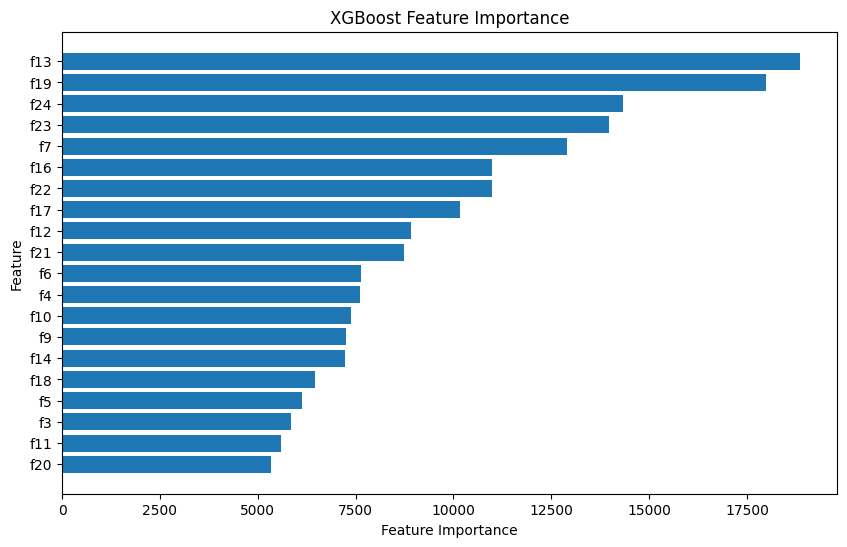

In [19]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb_importance = loaded_xgb.get_booster().get_score(importance_type='weight')
importances_df = pd.DataFrame(list(xgb_importance.items()), columns=['Feature', 'Importance'])
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'][:20], importances_df['Importance'][:20])  # Top 20 features
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

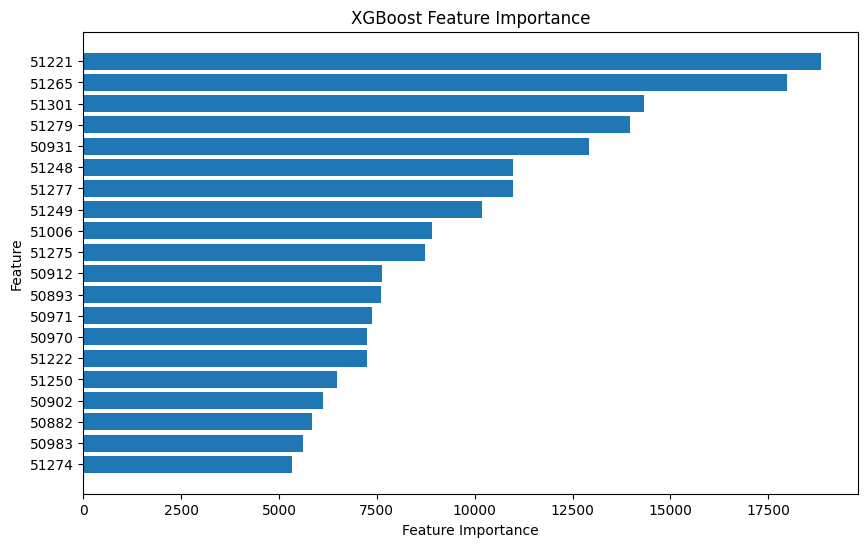

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# to extract names of features instead of numbers
feature_names = X.columns
xgb_importance = loaded_xgb.get_booster().get_score(importance_type='weight')

#dataframe for plottting
importances_df = pd.DataFrame({
    'Feature': [feature_names[int(k[1:])] if k[1:].isdigit() else k for k in xgb_importance.keys()],  # Convert indices to names
    'Importance': list(xgb_importance.values())
})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'][:20], importances_df['Importance'][:20])  # 20 features ka
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()


In [21]:
lab_df = pd.read_csv('/content/d_labitems.csv')
lab_test_name = lab_df[lab_df['itemid'] == 51265]
print(lab_test_name)

     itemid           label  fluid    category
451   51265  Platelet Count  Blood  Hematology


In [22]:
%pip install captum

In [23]:
import captum

In [24]:
# import shap
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from captum.attr import IntegratedGradients

# # Set ensemble weights
# w_xgb = 0.4
# w_pt = 0.3

# # Define the sample (assuming X_scaled[0] is the sample)
# single_sample = X_scaled[0:1]  # Shape: (1, num_features)
# single_sample_tensor = torch.tensor(single_sample, dtype=torch.float32).to(device)

# # -------------------- 1. SHAP for XGBoost --------------------
# explainer_xgb = shap.TreeExplainer(loaded_xgb)
# shap_values_xgb = explainer_xgb.shap_values(single_sample)  # Shape: (1203, num_features)

# # -------------------- 2. Get Top Predicted Class --------------------
# with torch.no_grad():
#     output = pytorch_model(single_sample_tensor)
#     top_pred_class = torch.argmax(output, dim=1).item()  # Get top class index

# # Extract SHAP values for the top-predicted class
# shap_values_xgb_top = shap_values_xgb[top_pred_class]  # Shape: (25,)

# # -------------------- 3. Integrated Gradients for NN --------------------
# ig = IntegratedGradients(pytorch_model)
# baseline = torch.zeros_like(single_sample_tensor)  # Baseline (zero input)
# attr, _ = ig.attribute(single_sample_tensor, baseline, target=top_pred_class, return_convergence_delta=True)
# attr = attr.cpu().detach().numpy().flatten()  # Shape: (25,)

# # -------------------- 4. Weight & Combine Importance --------------------
# combined_importance = (w_xgb * shap_values_xgb_top) + (w_pt * attr)  # Now both shapes are (25,)

# # -------------------- 5. Waterfall Plot --------------------
# feature_names = [f"Feature {i}" for i in range(single_sample.shape[1])]

# shap.waterfall_plot(shap.Explanation(
#     values=combined_importance,
#     base_values=0,  # Adjust if needed
#     feature_names=feature_names
# ))
# plt.show()

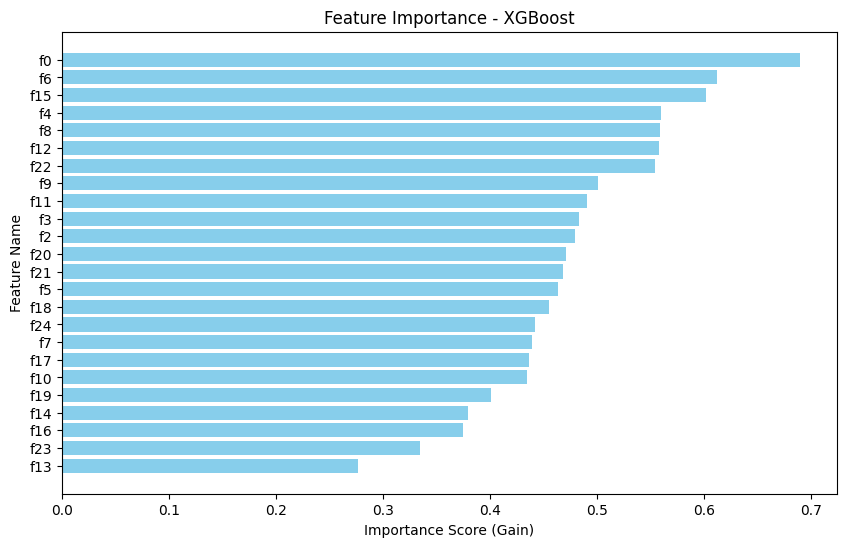

In [25]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Extract feature importance
feature_importance = loaded_xgb.get_booster().get_score(importance_type='gain')

# Sort by importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Convert to lists for plotting
features, scores = zip(*sorted_features)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, scores, color='skyblue')
plt.xlabel("Importance Score (Gain)")
plt.ylabel("Feature Name")
plt.title("Feature Importance - XGBoost")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

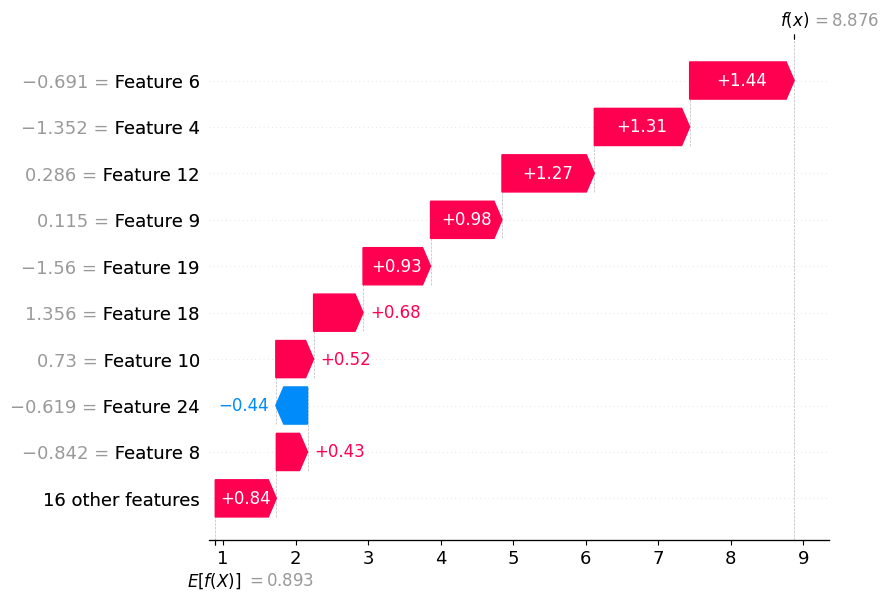

In [26]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Load SHAP explainer for XGBoost
explainer = shap.TreeExplainer(loaded_xgb)

# Sample 1 (assuming X_scaled is the input features)
X_sample = X_scaled[0:1]  # Extract the first sample

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)  # This returns SHAP values for each class

# Get the top predicted class for sample 1
xgb_probs = loaded_xgb.predict_proba(X_sample)  # Get probability scores
top_class = np.argmax(xgb_probs)  # Find the highest probability class

# Extract SHAP values for the top predicted class
# Extract SHAP values for the top predicted class (shape: (25,))
shap_top_class = shap_values[0, :, top_class]  # First sample, all features, specific class

# Waterfall Plot
shap.initjs()
shap.waterfall_plot(shap.Explanation(
    values=shap_top_class,
    base_values=explainer.expected_value[top_class],  # Use expected value for that class
    data=X_sample.squeeze(),
    feature_names=[f"Feature {i}" for i in range(X_sample.shape[1])]
))


In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load SHAP explainer for XGBoost
explainer = shap.TreeExplainer(loaded_xgb)

# Compute SHAP values for the entire dataset
shap_values = explainer.shap_values(X_scaled)

# Handle case when SHAP returns a list (multi-class case)
if isinstance(shap_values, list):
    predicted_classes = np.argmax(loaded_xgb.predict_proba(X_scaled), axis=1)
    selected_shap_values = np.array([shap_values[predicted_classes[i]][i, :] for i in range(X_scaled.shape[0])])
else:
    selected_shap_values = shap_values  # If it's already a NumPy array

# Convert to DataFrame for easy storage
shap_df = pd.DataFrame(selected_shap_values, columns=[f"Feature_{i}" for i in range(X_scaled.shape[1])])

# Save SHAP values to CSV
shap_df.to_csv("shap_values.csv", index=False)
print("SHAP values saved to 'shap_values.csv'.")

# Example: Plot SHAP values for the first sample
X_sample = X_scaled[0:1]  # Extract first sample
xgb_probs = loaded_xgb.predict_proba(X_sample)
top_class = np.argmax(xgb_probs)

# Extract SHAP values for top predicted class
if isinstance(shap_values, list):
    shap_top_class = shap_values[top_class][0, :]
else:
    shap_top_class = shap_values[0, :, top_class]

# Waterfall Plot
shap.initjs()
shap.waterfall_plot(shap.Explanation(
    values=shap_top_class,
    base_values=explainer.expected_value[top_class],
    data=X_sample.squeeze(),
    feature_names=[f"Feature {i}" for i in range(X_sample.shape[1])]
))


In [ ]:
print(type(shap_values))
if isinstance(shap_values, list):
    print("Multi-class model detected.")
    print(f"Number of classes: {len(shap_values)}")
    print(f"SHAP value shape per class: {shap_values[0].shape}")  # Print shape of the first class
else:
    print("Binary classification or regression model detected.")
    print(f"SHAP value shape: {shap_values.shape}")


In [ ]:
# Extract SHAP values for the top predicted class (shape: (25,))
shap_top_class = shap_values[0, :, top_class]  # First sample, all features, specific class

# Waterfall Plot
shap.initjs()
shap.waterfall_plot(shap.Explanation(
    values=shap_top_class,
    base_values=explainer.expected_value[top_class],  # Use expected value for that class
    data=X_sample.squeeze(),
    feature_names=[f"Feature {i}" for i in range(X_sample.shape[1])]
))


In [ ]:
print(f"Top predicted class: {top_class}")
print(f"Predicted probabilities: {xgb_probs}")

top_class = np.argmax(xgb_probs)  # Get index of the highest probability
top_prob = np.max(xgb_probs)  # Get the highest probability value
print(f"Top predicted class: {top_class}, Probability: {top_prob}")

In [ ]:
# import shap
# import numpy as np
# import matplotlib.pyplot as plt

# # Load SHAP explainer for XGBoost
# explainer = shap.TreeExplainer(loaded_xgb)

# # Sample 1 (assuming X_scaled is the input features)
# X_sample = X_scaled[0:1]  # Extract the first sample

# # Compute SHAP values
# shap_values = explainer.shap_values(X_sample)  # This returns SHAP values for each class

# # Get the top predicted class for sample 1
# xgb_probs = loaded_xgb.predict_proba(X_sample)  # Get probability scores
# top_class = np.argmax(xgb_probs)  # Find the highest probability class
# top_class_prob = xgb_probs[0, top_class]  # Get probability of the top predicted class

# # Print prediction details
# print(f"Predicted Class: {top_class}")
# print(f"Predicted Probability: {top_class_prob:.6f}")

# # Extract SHAP values for the top predicted class
# shap_top_class = shap_values[0, :, top_class]  # First sample, all features, specific class

# # Use actual feature names if available
# if isinstance(X_scaled, np.ndarray):
#     feature_names = loaded_xgb.get_booster().feature_names  # Extract feature names from XGBoost model
# else:
#     feature_names = X_scaled.columns.tolist()  # If X_scaled is a DataFrame, get column names

# # Waterfall Plot
# shap.initjs()
# shap.waterfall_plot(shap.Explanation(
#     values=shap_top_class,
#     base_values=explainer.expected_value[top_class],  # Use expected value for that class
#     data=X_sample.squeeze(),
#     feature_names=feature_names  # Use actual feature names
# ))
